### 1.1 Importar Libs

In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import json
import pickle
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

# Configurações de plotagem
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_style("whitegrid")

print("Bibliotecas importadas com sucesso!")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")

Bibliotecas importadas com sucesso!
Pandas: 2.3.3
NumPy: 2.3.3
Scikit-learn: 1.7.2


### 1.2 Carregar Datasets

In [2]:
# Carregamento e preparação inicial dos dados
print("Carregando datasets...")

# Carregar datasets pré-processados
train_data = pd.read_csv('../dataset_sepsis_prepared.csv')
test_data = pd.read_csv('../dataset_sepsis_test_prepared.csv')

print(f"Dataset de treino: {train_data.shape}")
print(f"Dataset de teste: {test_data.shape}")

# Separar features e target
X_train = train_data.drop('SepsisLabel', axis=1)
y_train = train_data['SepsisLabel']
X_test = test_data.drop('SepsisLabel', axis=1)
y_test = test_data['SepsisLabel']

# Normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nDistribuição das classes:")
print("Treino:", y_train.value_counts().to_dict())
print("Teste:", y_test.value_counts().to_dict())

Carregando datasets...


Dataset de treino: (853006, 19)
Dataset de teste: (215171, 19)

Distribuição das classes:
Treino: {0.0: 831112, 1.0: 21894}
Teste: {0.0: 209675, 1.0: 5496}

Distribuição das classes:
Treino: {0.0: 831112, 1.0: 21894}
Teste: {0.0: 209675, 1.0: 5496}


In [3]:
train_data.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,WBC,Platelets,Gender,Unit1,Unit2,HospAdmTime,ICULOS,Critical_Risk_Window,Time_Category,SepsisLabel
0,8,-1.109794,-0.460180,-0.936182,2.873365,3.044201,2.159974,-0.073601,-0.277186,-1.393580,0.450716,1.0,1.0,0.0,-12.06,9.0,0,0,0.0
1,47,0.569971,-2.437770,0.173477,0.393960,0.650783,0.430943,-0.997324,0.309171,0.245616,-0.275108,1.0,1.0,0.0,-0.05,48.0,0,1,0.0
2,6,0.150030,0.978068,0.016114,-0.983487,-0.553850,-0.198683,-0.073601,-0.310739,0.121368,-0.191266,1.0,1.0,0.0,-0.02,7.0,0,0,0.0
3,39,-0.269912,0.258944,0.289355,0.853109,0.405094,-0.115460,0.752015,0.298591,-0.003965,-3.152920,0.0,0.0,1.0,-75.85,43.0,0,1,0.0
4,127,0.569971,-0.460180,0.007012,0.761279,1.834255,1.055050,-0.520987,0.702140,-0.180545,0.030433,0.0,0.0,1.0,-0.03,128.0,1,2,0.0


## 2. Sampling para Busca de Hiperparâmetros

In [9]:
# ======================================================================
# SAMPLING ESTRATIFICADO PARA BUSCA DE HIPERPARÂMETROS
# ======================================================================

print("=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===")

# Amostra estratificada do dataset de treino
_, X_sample, _, y_sample = train_test_split(
    X_train_scaled, y_train, 
    test_size=0.005,  
    stratify=y_train,
    random_state=10
)

print(f"Dataset original de treino: {X_train_scaled.shape[0]:,} amostras")
print(f"Amostra para busca de hiperparâmetros: {X_sample.shape[0]:,} amostras")
print(f"Redução: {(1 - X_sample.shape[0]/X_train_scaled.shape[0])*100:.1f}%")

print("\nDistribuição das classes na amostra:")
print("Amostra:", pd.Series(y_sample).value_counts().to_dict())
print("Original:", y_train.value_counts().to_dict())

=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===
Dataset original de treino: 853,006 amostras
Amostra para busca de hiperparâmetros: 4,266 amostras
Redução: 99.5%

Distribuição das classes na amostra:
Amostra: {0.0: 4157, 1.0: 109}
Original: {0.0: 831112, 1.0: 21894}
Dataset original de treino: 853,006 amostras
Amostra para busca de hiperparâmetros: 4,266 amostras
Redução: 99.5%

Distribuição das classes na amostra:
Amostra: {0.0: 4157, 1.0: 109}
Original: {0.0: 831112, 1.0: 21894}


## 3.1 Funções Auxiliares

In [5]:
# Função auxiliar para cálculo do G-Mean
def gmean_score(y_true, y_pred):
    """Calcula o G-Mean (Geometric Mean) para problemas binários"""
    # Sensitivity (recall da classe positiva - sepsis)
    sensitivity = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    # Specificity (recall da classe negativa - sem sepsis)
    specificity = recall_score(y_true, y_pred, pos_label=0, zero_division=0)
    # G-Mean é a média geométrica de sensitivity e specificity
    return np.sqrt(sensitivity * specificity)

# Função para avaliar modelos
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Avalia um modelo treinado e retorna métricas completas"""
    # Predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métricas de treino
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_train_pred),
        'precision': precision_score(y_train, y_train_pred, zero_division=0),
        'recall': recall_score(y_train, y_train_pred, zero_division=0),
        'f1': f1_score(y_train, y_train_pred, zero_division=0),
        'gmean': gmean_score(y_train, y_train_pred)
    }
    
    # Métricas de teste
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred, zero_division=0),
        'recall': recall_score(y_test, y_test_pred, zero_division=0),
        'f1': f1_score(y_test, y_test_pred, zero_division=0),
        'gmean': gmean_score(y_test, y_test_pred)
    }
    
    # AUC-ROC para problemas binários
    try:
        y_test_proba = model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva
        test_metrics['auc_roc'] = roc_auc_score(y_test, y_test_proba)
        
        # AUC-ROC para treino também
        y_train_proba = model.predict_proba(X_train)[:, 1]
        train_metrics['auc_roc'] = roc_auc_score(y_train, y_train_proba)
    except Exception as e:
        test_metrics['auc_roc'] = None
        train_metrics['auc_roc'] = None
    
    return train_metrics, test_metrics, y_test_pred

# Função para plotar histórico de busca
def plot_search_history(all_search_results, search_results, model_name, metric='mean_test_score'):
    """Plota a evolução dos resultados durante a busca de hiperparâmetros"""
        
    plt.figure(figsize=(15, 6))
        
    results_df = pd.DataFrame(search_results.cv_results_)
    # Extrair melhor score de cada busca
    search_scores = []
    search_indices = []
    
    for i, search_result in enumerate(all_search_results):
        search_scores.append(search_result['best_score'])
        search_indices.append(i + 1)
    
    plt.subplot(1, 2, 1)
    plt.plot(search_indices, search_scores, 'b-o', alpha=0.8, markersize=8)
    plt.title(f'{model_name} - Melhor F1-Score por Busca')
    plt.xlabel('Número da Busca')
    plt.ylabel('Melhor F1-Score')
    plt.grid(True, alpha=0.3)
    
    # Destacar a melhor busca
    best_idx = search_scores.index(max(search_scores))
    plt.plot(search_indices[best_idx], search_scores[best_idx], 'ro', markersize=12, 
            label=f'Melhor: {search_scores[best_idx]:.4f}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    # Verificar se existe coluna de treino
    if 'mean_train_score' in results_df.columns:
        # Plotar treino com sombra
        plt.plot(results_df['mean_train_score'], 'g-o', alpha=0.7, label='Treino')
        plt.fill_between(range(len(results_df)), 
                        results_df['mean_train_score'] - results_df['std_train_score'],
                        results_df['mean_train_score'] + results_df['std_train_score'], 
                        color='green', alpha=0.2)
    
    # Plotar validação com sombra
    plt.plot(results_df[metric], 'b-o', alpha=0.7, label='Validação')
    plt.fill_between(range(len(results_df)), 
                    results_df[metric] - results_df['std_test_score'],
                    results_df[metric] + results_df['std_test_score'], 
                    color='blue', alpha=0.3)
    
    # DESTACAR A MELHOR ITERAÇÃO
    best_iteration_idx = results_df[metric].idxmax()
    best_iteration_score = results_df[metric].iloc[best_iteration_idx]
    
    plt.plot(best_iteration_idx, best_iteration_score, 'ro', markersize=15, 
            markeredgecolor='darkred', markeredgewidth=2,
            label=f'Melhor iteração: #{best_iteration_idx + 1} ({best_iteration_score:.4f})')
    
    plt.title(f'{model_name} - Treino vs Validação (Melhor Busca)')
    plt.xlabel('Iteração')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Função para executar múltiplas buscas de hiperparâmetros
def multiple_randomized_search(estimator, param_distributions, X, y, cv_strategy, 
                              n_searches=20, n_iter_per_search=80, scoring='f1', 
                              random_state=42, n_jobs=-1, verbose=0):
    """
    Executa múltiplas buscas RandomizedSearchCV e retorna a melhor configuração global
    
    Parameters:
    -----------
    n_searches : int
        Número de execuções do RandomizedSearchCV (default: 20)
    n_iter_per_search : int  
        Número de iterações por execução (default: 80)
    """
    print(f"Executando {n_searches} buscas com {n_iter_per_search} iterações cada...")
    
    best_overall_score = -np.inf
    best_overall_params = None
    best_search_result = None
    all_results = []
    
    for search_idx in range(n_searches):
        print(f"\nBusca {search_idx + 1}/{n_searches}...")
        
        # RandomizedSearchCV para esta execução
        search = RandomizedSearchCV(
            estimator=estimator,
            param_distributions=param_distributions,
            n_iter=n_iter_per_search,
            scoring=scoring,
            cv=cv_strategy,
            random_state=None,
            n_jobs=n_jobs,
            return_train_score=True,
            verbose=0  # Menos verbose para múltiplas execuções
        )
        
        search.fit(X, y)
        
        # Armazenar resultados desta busca
        search_results = {
            'search_idx': search_idx,
            'best_score': search.best_score_,
            'best_params': search.best_params_,
            'cv_results': search.cv_results_
        }
        all_results.append(search_results)
        
        # Verificar se esta é a melhor busca até agora
        if search.best_score_ > best_overall_score:
            best_overall_score = search.best_score_
            best_overall_params = search.best_params_
            best_search_result = search
            
        print(f"Melhor score desta busca: {search.best_score_:.4f}")
        print(f"Melhor configuração desta busca: {search.best_params_}")
        print(f"Melhor score geral até agora: {best_overall_score:.4f}")
    
    print(f"\n🎯 Busca completa! Melhor score geral: {best_overall_score:.4f}")
    print(f"Total de configurações testadas: {n_searches * n_iter_per_search:,}")
    
    return best_search_result, all_results, best_overall_params


# Função para plotar histórico de busca a partir de loaded_results
def plot_search_history_from_loaded(loaded_results, model_name, metric='mean_test_score'):
    """Plota a evolução dos resultados a partir de loaded_results"""
    
    plt.figure(figsize=(15, 6))
    
    # Extrair dados do loaded_results
    detailed_df = loaded_results['detailed_df']
    
    # Agrupar por search_idx para obter o melhor de cada busca
    best_per_search = detailed_df.groupby('search_idx')['mean_test_score'].max().reset_index()
    best_per_search['search_number'] = best_per_search['search_idx'] + 1  # 1-indexado
    
    # GRÁFICO 1: Melhor F1-Score por Busca
    plt.subplot(1, 2, 1)
    plt.plot(best_per_search['search_number'], best_per_search['mean_test_score'], 
             'b-o', alpha=0.8, markersize=8)
    plt.title(f'{model_name} - Melhor F1-Score por Busca')
    plt.xlabel('Número da Busca')
    plt.ylabel('Melhor F1-Score')
    plt.grid(True, alpha=0.3)
    
    # Destacar a melhor busca
    best_search_idx = best_per_search['mean_test_score'].idxmax()
    best_search_score = best_per_search['mean_test_score'].iloc[best_search_idx]
    best_search_number = best_per_search['search_number'].iloc[best_search_idx]
    
    plt.plot(best_search_number, best_search_score, 'ro', markersize=12, 
             label=f'Melhor: {best_search_score:.4f}')
    plt.legend()
    
    # GRÁFICO 2: Iterações da melhor busca
    plt.subplot(1, 2, 2)
    
    # Encontrar qual search_idx teve o melhor score geral
    best_overall_idx = detailed_df['mean_test_score'].idxmax()
    best_overall_search_idx = detailed_df.loc[best_overall_idx, 'search_idx']
    
    # Filtrar dados apenas da melhor busca
    best_search_data = detailed_df[detailed_df['search_idx'] == best_overall_search_idx].copy()
    best_search_data = best_search_data.sort_values('iteration').reset_index(drop=True)
    
    # Criar eixo X 1-indexado para iterações
    iterations_1indexed = range(1, len(best_search_data) + 1)
    
    # Verificar se existe coluna de treino
    if 'mean_train_score' in best_search_data.columns and best_search_data['mean_train_score'].notna().any():
        # Plotar treino com sombra
        plt.plot(iterations_1indexed, best_search_data['mean_train_score'], 
                'g-o', alpha=0.7, label='Treino')
        plt.fill_between(iterations_1indexed, 
                         best_search_data['mean_train_score'] - best_search_data['std_train_score'],
                         best_search_data['mean_train_score'] + best_search_data['std_train_score'], 
                         color='green', alpha=0.2)
    
    # Plotar validação com sombra
    plt.plot(iterations_1indexed, best_search_data[metric], 'b-o', alpha=0.7, label='Validação')
    plt.fill_between(iterations_1indexed, 
                     best_search_data[metric] - best_search_data['std_test_score'],
                     best_search_data[metric] + best_search_data['std_test_score'], 
                     color='blue', alpha=0.3)
    
    # DESTACAR A MELHOR ITERAÇÃO
    best_iteration_idx = best_search_data[metric].idxmax()
    best_iteration_score = best_search_data[metric].iloc[best_iteration_idx]
    best_iteration_number = best_iteration_idx + 1  # 1-indexado
    
    plt.plot(best_iteration_number, best_iteration_score, 'ro', markersize=15, 
             markeredgecolor='darkred', markeredgewidth=2,
             label=f'Melhor iteração: #{best_iteration_number} ({best_iteration_score:.4f})')
    
    plt.title(f'{model_name} - Treino vs Validação (Melhor Busca #{best_overall_search_idx + 1})')
    plt.xlabel('Iteração')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

print("Funções auxiliares definidas com sucesso!")

Funções auxiliares definidas com sucesso!


## 3.2 Definir Folds

In [6]:
# Configuração da validação cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## 4. MLP - Busca de Hiperparâmetros

In [7]:
# Definir nome do modelo para uso em salvamento e exibição
MODEL_NAME = "MLP"

In [10]:
# ======================================================================
# 4.1 BUSCA DE HIPERPARAMETROS
# ======================================================================

print(f"=== BUSCA DE HIPERPARÂMETROS - {MODEL_NAME} ===")

# Definição do Espaço de Hiperparâmetros para MLP
param_distributions = {
    'hidden_layer_sizes': [(100, 100, 100), (100, 100, 100, 100),
                           (200, 200, 200), (200, 200, 200, 200),
                            (50, 100, 200, 300), (300, 200, 100, 50), 
                           (50, 50, 50, 50), (100, 100, 50, 50),
                           (100, 50, 100, 50), (100, 50, 200), (200, 300, 100)],
    'alpha': uniform(0.01, 0.1),  # Regularização L2
    'learning_rate_init': uniform(0.001, 0.1),  # Taxa de aprendizado inicial
    'max_iter': randint(200, 600),  # Número máximo de iterações
    'activation': ['relu', 'tanh', 'logistic'],  # Função de ativação
    'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Estratégia de taxa de aprendizado
}

# Múltiplas execuções do RandomizedSearchCV
print(f"Iniciando busca de hiperparâmetros para {MODEL_NAME}...")
model_search, model_all_searches, best_params = multiple_randomized_search(
    estimator=MLPClassifier(random_state=42, early_stopping=True, solver='lbfgs'),
    param_distributions=param_distributions,
    X=X_sample,                  
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=20,                
    n_iter_per_search=5,        
    scoring='f1',
    n_jobs=-1,
)

# Seleção da Melhor Configuração
print(f"\n--- RESULTADOS {MODEL_NAME} ---")
print("Melhores hiperparâmetros:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nMelhor F1-Score (CV): {model_search.best_score_:.4f}")

=== BUSCA DE HIPERPARÂMETROS - MLP ===
Iniciando busca de hiperparâmetros para MLP...
Executando 20 buscas com 5 iterações cada...

Busca 1/20...
Melhor score desta busca: 0.1173
Melhor configuração desta busca: {'activation': 'tanh', 'alpha': np.float64(0.09261401746002747), 'hidden_layer_sizes': (200, 300, 100), 'learning_rate': 'adaptive', 'learning_rate_init': np.float64(0.0863088682304401), 'max_iter': 214}
Melhor score geral até agora: 0.1173

Busca 2/20...
Melhor score desta busca: 0.1173
Melhor configuração desta busca: {'activation': 'tanh', 'alpha': np.float64(0.09261401746002747), 'hidden_layer_sizes': (200, 300, 100), 'learning_rate': 'adaptive', 'learning_rate_init': np.float64(0.0863088682304401), 'max_iter': 214}
Melhor score geral até agora: 0.1173

Busca 2/20...
Melhor score desta busca: 0.1222
Melhor configuração desta busca: {'activation': 'tanh', 'alpha': np.float64(0.022423919995368927), 'hidden_layer_sizes': (50, 50, 50, 50), 'learning_rate': 'constant', 'learning

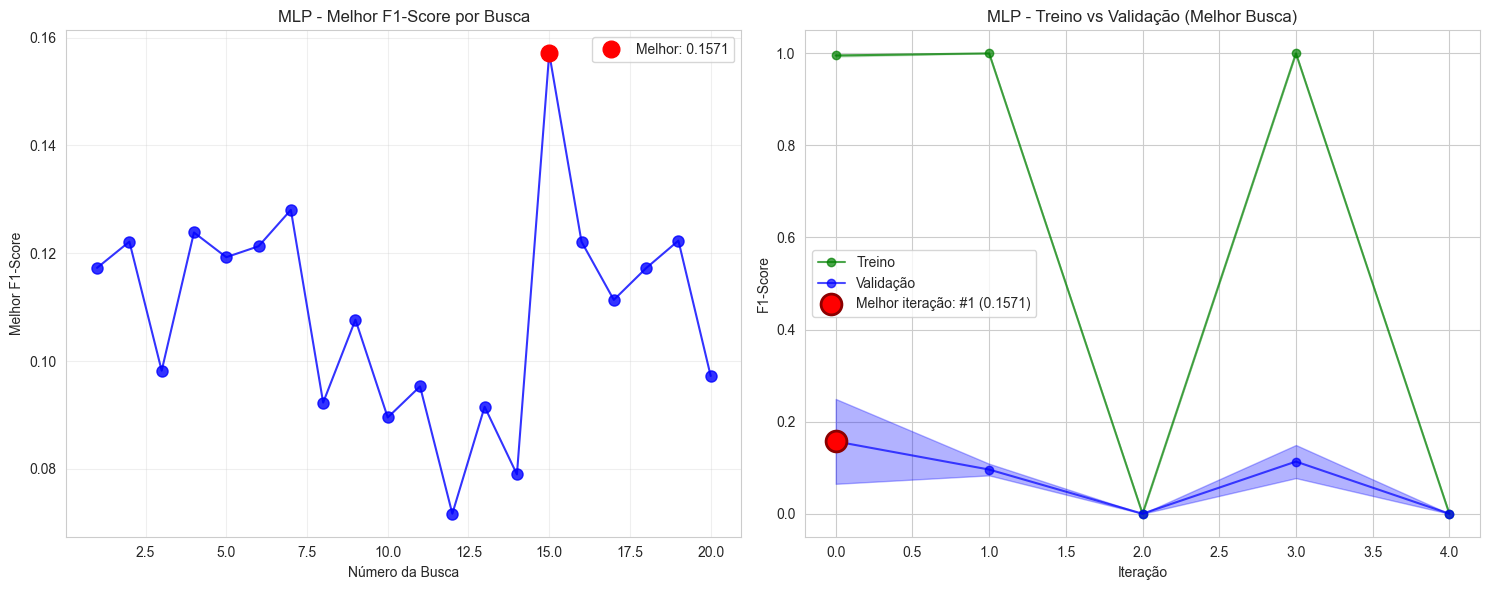

In [11]:
# Registro de Desempenho - plotar evolução
plot_search_history(model_all_searches, model_search, MODEL_NAME)

In [14]:
# ======================================================================
# 4.5 ANÁLISE DAS MELHORES CONFIGURAÇÕES ENCONTRADAS
# ======================================================================

print(f"=== MELHORES CONFIGURAÇÕES ENCONTRADAS POR BUSCA - {MODEL_NAME} ===")

# Extrair os melhores resultados de cada busca
best_configs = []

for i, search_result in enumerate(model_all_searches):
    config = {
        'Busca': i + 1,
        'F1_Score': search_result['best_score'],
        'Hidden_Layers': str(search_result['best_params']['hidden_layer_sizes']),
        'Alpha': search_result['best_params']['alpha'],
        'Learning_Rate_Init': search_result['best_params']['learning_rate_init'],
        'Learning_Rate': search_result['best_params']['learning_rate'],
        'Max_Iter': search_result['best_params']['max_iter'],
        'Activation': search_result['best_params']['activation']
    }
    best_configs.append(config)

# Converter para DataFrame e ordenar por F1-Score
results_df = pd.DataFrame(best_configs)
results_df = results_df.sort_values('F1_Score', ascending=False).reset_index(drop=True)
results_df['Ranking'] = range(1, len(results_df) + 1)

# Reordenar colunas
results_df = results_df[['Ranking', 'Busca', 'F1_Score', 'Hidden_Layers', 'Alpha', 
                        'Learning_Rate_Init', 'Learning_Rate', 'Max_Iter', 'Activation']]

# Mostrar tabela formatada
print("Melhores Configurações de Cada Busca (ordenadas por F1-Score Binário):")
print("-" * 150)
print(results_df.to_string(index=False, float_format='%.4f'))

# Estatísticas resumidas
print(f"\n--- ESTATÍSTICAS DAS CONFIGURAÇÕES ---")
print(f"Melhor F1-Score: {results_df['F1_Score'].max():.4f}")
print(f"F1-Score médio: {results_df['F1_Score'].mean():.4f}")
print(f"Desvio padrão: {results_df['F1_Score'].std():.4f}")
print(f"F1-Score mínimo: {results_df['F1_Score'].min():.4f}")

=== MELHORES CONFIGURAÇÕES ENCONTRADAS POR BUSCA - MLP ===
Melhores Configurações de Cada Busca (ordenadas por F1-Score Binário):
------------------------------------------------------------------------------------------------------------------------------------------------------
 Ranking  Busca  F1_Score        Hidden_Layers  Alpha  Learning_Rate_Init Learning_Rate  Max_Iter Activation
       1     15    0.1571      (100, 100, 100) 0.1052              0.0824      adaptive       446       tanh
       2      7    0.1280     (50, 50, 50, 50) 0.0158              0.0321    invscaling       316       relu
       3      4    0.1239      (100, 100, 100) 0.0157              0.0860      constant       211       tanh
       4     19    0.1223      (100, 100, 100) 0.0952              0.0680      adaptive       258       tanh
       5      2    0.1222     (50, 50, 50, 50) 0.0224              0.0401      constant       249       tanh
       6     16    0.1221      (200, 300, 100) 0.0230            

## 5. Salvar Resultados de Busca
Seção serve somente para salvar o resultado de toda a busca num CSV e os dados essenciais no JSON.

In [16]:
# Salvar Resultados da Busca de Hiperparâmetros

print(f"=== SALVANDO RESULTADOS DA BUSCA - {MODEL_NAME} ===")

# Criar pasta se não existir
os.makedirs('searches', exist_ok=True)

# 1. Salvar resultados detalhados de todas as buscas
search_detailed_results = []

for i, search_result in enumerate(model_all_searches):
    # Extrair informações de cada busca individual
    cv_results = search_result['cv_results']
    
    for j in range(len(cv_results['mean_test_score'])):
        search_detailed_results.append({
            'search_idx': search_result['search_idx'],
            'iteration': j,
            'mean_test_score': cv_results['mean_test_score'][j],
            'std_test_score': cv_results['std_test_score'][j],
            'mean_train_score': cv_results['mean_train_score'][j] if 'mean_train_score' in cv_results else None,
            'std_train_score': cv_results['std_train_score'][j] if 'std_train_score' in cv_results else None,
            'params': str(cv_results['params'][j]),
            **{k: v for k, v in cv_results['params'][j].items() if k != 'hidden_layer_sizes'},
            'hidden_layer_sizes': str(cv_results['params'][j]['hidden_layer_sizes'])
        })

# Converter para DataFrame e salvar
search_df = pd.DataFrame(search_detailed_results)
search_df.to_csv(f'searches/{MODEL_NAME.lower()}_all_searches.csv', index=False)

print(f"  Todos os Resultados salvos: searches/{MODEL_NAME.lower()}_all_searches.csv")
print(f"  Total de configurações testadas: {len(search_df):,}")

# 2. Salvar resumo da melhor busca
best_search_summary = {
    'model_name': MODEL_NAME,
    'best_overall_score': model_search.best_score_,
    'best_overall_params': {k: str(v) if isinstance(v, tuple) else v for k, v in model_search.best_params_.items()},
    'search_config': {
        'n_searches': 20,
        'n_iter_per_search': 10,
        'scoring': 'f1',
        'cv_folds': 5,
        'total_configurations': len(search_df)
    },
    'top_10_configs': search_df.nlargest(10, 'mean_test_score')[
        ['mean_test_score', 'std_test_score', 'alpha', 'learning_rate_init', 
         'max_iter', 'activation', 'hidden_layer_sizes']
    ].to_dict('records')
}

# Salvar resumo em JSON
with open(f'searches/{MODEL_NAME.lower()}_search_summary.json', 'w') as f:
    json.dump(best_search_summary, f, indent=2)

print(f"  Resumo salvo: searches/{MODEL_NAME.lower()}_search_summary.json")

# Mostrar estatísticas da busca
print(f"\n--- ESTATÍSTICAS DA BUSCA {MODEL_NAME} ---")
print(f"Melhor F1-Score: {model_search.best_score_:.4f}")
print(f"Desvio padrão do melhor: {search_df.loc[search_df['mean_test_score'].idxmax(), 'std_test_score']:.4f}")
print(f"F1-Score médio geral: {search_df['mean_test_score'].mean():.4f}")
print(f"F1-Score mínimo: {search_df['mean_test_score'].min():.4f}")
print(f"F1-Score máximo: {search_df['mean_test_score'].max():.4f}")

=== SALVANDO RESULTADOS DA BUSCA - MLP ===
  Todos os Resultados salvos: searches/mlp_all_searches.csv
  Total de configurações testadas: 100
  Resumo salvo: searches/mlp_search_summary.json

--- ESTATÍSTICAS DA BUSCA MLP ---
Melhor F1-Score: 0.1571
Desvio padrão do melhor: 0.0922
F1-Score médio geral: 0.0653
F1-Score mínimo: 0.0000
F1-Score máximo: 0.1571


## 5.2 Carregar Resultado de busca

In [ ]:
def load_search_results(model_name, searches_folder='searches'):
    """
    Carrega resultados de busca salvos anteriormente
    
    Returns:
    --------
    dict: Dicionário com todos os resultados carregados
    """
    print(f"=== CARREGANDO RESULTADOS DE BUSCA - {model_name.upper()} ===")
    
    results = {}
    
    # 1. Carregar DataFrame detalhado
    csv_path = os.path.join(searches_folder, f'{model_name.lower()}_all_searches.csv')
    if os.path.exists(csv_path):
        results['detailed_df'] = pd.read_csv(csv_path)
        print(f"✅ Resultados detalhados carregados: {len(results['detailed_df']):,} configurações")
    else:
        print(f"⚠️  Arquivo não encontrado: {csv_path}")
    
    # 2. Carregar resumo JSON
    json_path = os.path.join(searches_folder, f'{model_name.lower()}_search_summary.json')
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            results['summary'] = json.load(f)
        print(f"✅ Resumo carregado: F1-Score = {results['summary']['best_overall_score']:.4f}")
    else:
        print(f"⚠️  Arquivo não encontrado: {json_path}")
    
    # 3. Carregar backup pickle
    pkl_path = os.path.join(searches_folder, f'{model_name.lower()}_full_search.pkl')
    if os.path.exists(pkl_path):
        with open(pkl_path, 'rb') as f:
            results['full_backup'] = pickle.load(f)
        print(f"✅ Backup completo carregado")
    else:
        print(f"⚠️  Arquivo não encontrado: {pkl_path}")
    
    return results


def get_best_params_from_saved(model_name, searches_folder='searches'):
    """
    Recupera os melhores parâmetros de arquivos salvos
    
    Returns:
    --------
    dict: Melhores parâmetros encontrados
    """
    # Tentar carregar do JSON primeiro
    json_path = os.path.join(searches_folder, f'{model_name.lower()}_search_summary.json')
    
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            summary = json.load(f)
        return summary['best_overall_params']
    
    # Fallback para pickle
    pkl_path = os.path.join(searches_folder, f'{model_name.lower()}_full_search.pkl')
    if os.path.exists(pkl_path):
        with open(pkl_path, 'rb') as f:
            backup = pickle.load(f)
        return backup['best_params']
    
    print(f"❌ Não foi possível carregar parâmetros para {model_name}")
    return None


In [ ]:
#### 4.2 Carregar Resultados Salvos (Função Auxiliar)
# Exemplo de uso da função (não executar se já temos os resultados)
loaded_results = load_search_results(MODEL_NAME)

In [ ]:
# Plotar a história da busca a partir dos resultados carregados
plot_search_history_from_loaded(loaded_results, MODEL_NAME)

In [ ]:

#### 4.3 Recuperar Melhores Parâmetros para Uso Posterior
# Exemplo de uso (descomente se precisar carregar parâmetros salvos):
if 'loaded_results' in locals():
    best_params = get_best_params_from_saved(MODEL_NAME)
    if best_params:
        print(f"✅ Parâmetros carregados: {best_params}")
    best_score = loaded_results['summary']['best_overall_score']
    print(f"✅ Melhor F1-Score carregado: {best_score:.4f}")
else:
    best_params = model_search.best_params_
    best_score = model_search.best_score_
    print(f"✅ Usando parâmetros da busca atual: {best_params}")
    print(f"✅ Melhor F1-Score da busca atual: {best_score:.4f}")

## 6. Treinar Modelo Final e Salvar

In [ ]:
# Treinamento Final com melhores hiperparâmetros

best_model = MLPClassifier(**best_params, random_state=42)

best_model.fit(X_train_scaled, y_train)

print(f"\nModelo final {MODEL_NAME} treinado: {best_model}")

# Criar pasta se não existir
os.makedirs('models', exist_ok=True)

# Salvar modelo treinado
dump(best_model, f'models/{MODEL_NAME.lower()}_trained.joblib')
print(f"Modelo salvo: models/{MODEL_NAME.lower()}_trained.joblib")

## 7. Avaliação Final e Salvamento dos Resultados

In [ ]:
# Carregar modelo
loaded_model = load(f'models/{MODEL_NAME.lower()}_trained.joblib')

In [ ]:
print(f"=== AVALIAÇÃO E SALVAMENTO DOS RESULTADOS - {MODEL_NAME} ===")

# Criar pastas se não existirem
os.makedirs('results', exist_ok=True)

# Avaliação completa do modelo
print("\nAvaliando performance do modelo...")

if 'loaded_model' in locals():
    model = loaded_model
else:
    model = best_model

X_train_eval = X_train_scaled
y_train_eval = y_train
X_test_eval = X_test_scaled
y_test_eval = y_test

# Avaliar modelo
train_metrics, test_metrics, y_pred = evaluate_model(
    model, X_train_eval, X_test_eval, y_train_eval, y_test_eval, MODEL_NAME
)


In [ ]:
# Compilar todos os resultados
model_final_results = {
    'model_name': MODEL_NAME,
    'best_params': best_params,
    'best_cv_score': best_score,
    'train_metrics': train_metrics,
    'test_metrics': test_metrics,
    'predictions': y_pred.tolist(),
    'test_labels': y_test_eval.tolist(),
    'evaluation_info': {
        'train_samples_used': len(X_train_eval),
        'test_samples_used': len(X_test_eval),
        'total_train_samples': len(X_train_scaled),
        'total_test_samples': len(X_test_scaled)
    }
}

# Salvar resultados em JSON
with open(f'results/{MODEL_NAME.lower()}_results.json', 'w') as f:
    json.dump(model_final_results, f, indent=2)

print(f"Resultados {MODEL_NAME} salvos em: results/{MODEL_NAME.lower()}_results.json")

# Mostrar resumo
print(f"\n--- RESUMO {MODEL_NAME} ---")
print(f"F1-Score CV: {model_final_results['best_cv_score']:.4f}")
print(f"F1-Score Teste: {test_metrics['f1']:.4f}")
print(f"Acurácia Teste: {test_metrics['accuracy']:.4f}")
print(f"Precisão Teste: {test_metrics['precision']:.4f}")
print(f"Recall Teste: {test_metrics['recall']:.4f}")
print(f"G-Mean Teste: {test_metrics['gmean']:.4f}")
if test_metrics['auc_roc']:
    print(f"AUC-ROC Teste: {test_metrics['auc_roc']:.4f}")